<h1 style="font-family: Arial, sans-serif; font-size: 40px; color: white; text-align: center; margin-top: 40px;">Project 1A - Genetic Algorithms for Feature
Selection using Python</h1>
    <h2 style="font-family: Arial, serif; font-size: 24px; color: white; text-align: center; margin-top: 20px;">By Nick Askari and Simen Peder Stang</h2>

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import LinReg
import pandas as pd

## Defining paramters for the SGA

In [3]:
pop_size = 100
chromosome_length = 90
generation_number = 1
crossover_rate = 0.9
mutation_rate = 0.1
num_parents = int(np.floor(pop_size/2))
g_max = 10
enable_constraint = (False, [5, 10])

data = pd.read_csv("dataset.txt", header=None)
regressor = LinReg.LinReg()

## Defining the Individual

In [4]:
class Individual:
    def __init__(self, genotype, age) -> None:
        self.genotype = genotype
        self.phenotype = int(genotype, 2)
        self.age = age
        self.sin_fitness = self.calculate_sin_fitness()
        self.rmse_fitness = self.calculate_rmse_fitness()

    def scaled_phenotype(self):
        genotype_length = len(self.genotype)
        scaling_factor = (2**7) / (2**genotype_length)
        scaled_value = self.phenotype * scaling_factor
        return scaled_value
    
    def calculate_sin_fitness(self):
        x = self.scaled_phenotype()

        # Handle if there is a constraint
        if enable_constraint[0]:
            distance = self.calculate_distance(x)
            fitness = np.sin(x) + 1 - distance
            if fitness < 0:
                return 0
            else:
                return fitness
        else:
            # Scaling by 1 to avoid negative values
            return np.sin(x) + 1
    
    def calculate_rmse_fitness(self):
        y = np.array([int(bit) for bit in self.genotype])
        X = regressor.get_columns(data.values, y)

        # Return rmse based on whether feature selection is activated (related to task g))

        return regressor.get_fitness(X[:,:-1], X[:,-1])

    def calculate_distance(self, x):
        lower_bound, upper_bound = enable_constraint[1][0], enable_constraint[1][1]
        if x < lower_bound:
            return lower_bound - x
        elif x > upper_bound:
            return x - upper_bound
        else:
            return 0

    def grow_older(self):
        self.age += 1
    
    def __repr__(self):
        return f"Individual(genotype={self.genotype}, phenotype={self.phenotype}, sin_fitness={self.sin_fitness}, age={self.age})"
    
    def __hash__(self):
        return hash((self.genotype, self.phenotype))

## Sin Synthetic Problem

*a) Implement a function to generate an initial population for your genetic
algorithm.*

We are choosing to initialize the population, according to the size parameters. The actual genotypes (0's and 1's) will be generated randomly.

In [5]:
def init_population():
    population = []
    
    for _ in range(pop_size):
        new_genotype = ""
        for _ in range(chromosome_length):
            new_genotype += str(random.randint(0,1))

        new_individual = Individual(new_genotype, age=0)
        population.append(new_individual)
    return population

*b) Implement a parent selection function for your genetic algorithm. This function
should find the fittest individuals in the population, and select parents based
on this fitness.*

Here we are using the fitness function given by the sine function, as explained in the task. Moreover we are implementing a roulette-wheel approach as parent selection.

In [6]:
def roulette_wheel_parent_selection(population, use_dataset):    
    # Probability of choosing each individual based on the roulette wheel approach
    if use_dataset:
        # Minimizing
        total_fitness = sum(1.0 / individual.rmse_fitness for individual in population)
        probabilities = [(1.0 / individual.rmse_fitness) / total_fitness for individual in population]
    else:
        # Maximizing
        total_fitness = sum(individual.sin_fitness for individual in population)
        probabilities = [individual.sin_fitness/total_fitness for individual in population]

    # Choosing num_parents parents with the above probabilities for each individual
    parents = np.random.choice(population, size=num_parents, p=probabilities)
    
    return list(parents)

*c) Implement a function that creates two offspring from two parents through
crossover. The offspring should also have a chance of getting a random
mutation.*

In [7]:
def crossover(parent1, parent2):
    gene_cutoff = random.randint(1, chromosome_length - 1)

    genotype_1 = parent1.genotype[: gene_cutoff] + parent2.genotype[gene_cutoff:]
    genotype_2 = parent2.genotype[: gene_cutoff] + parent1.genotype[gene_cutoff:]

    child_1 = Individual(mutate(genotype_1), age=0)
    child_2 = Individual(mutate(genotype_2), age=0)

    return child_1, child_2
        
def mutate(genotype):
    if np.random.random() < mutation_rate:
        char_list = list(genotype)

        random_index = np.random.randint(len(char_list))

        char_list[random_index] = '0' if char_list[random_index] == '1' else '1'

        return ''.join(char_list)
    else:
        return genotype

*d) Implement survivor selection.*

- For a 1-person team: Implement one survivor selection function that
selects the survivors of a population based on their fitness.
- For a 2-person team: Implement two such survivor selection functions.

Survivor selection function 1 chooses based on age. It sorts the population based on age, from youngest to oldest. Then outputs the youngest individuals.

In [8]:
def age_selection(population):
    age_sorted_population = sorted(population, key=lambda x: x.age)
    return age_sorted_population[:pop_size]

Survivor selection function 2 uses tounrament selection. A set of individuals is randomly chosen, and the one with the highest fitness within this group is selected to survive. This process is repeated until the desired number of survivors is reached.

In [9]:
# UNSURE IF THIS IS CROWDING (SHOULD WE CHANGE THIS --> CHATGPT SAYS NOT)

def tournament_selection(population, use_dataset):
    contestants = population.copy()
    winners = []

    while len(winners) != pop_size:
        if len(contestants) > 1:
            size = random.randint(2, len(contestants))
            trial = np.random.choice(contestants, size, replace=False)
            
            if use_dataset:
                winner = min(trial, key=lambda x: x.rmse_fitness)
            else:
                winner = max(trial, key=lambda x: x.sin_fitness)
            contestants.remove(winner)
            
            winners.append(winner)
        else:
            winner = contestants[0]
            winners.append(winner)
    
    return list(winners)

*e) Connect all the implemented functions to complete the genetic algorithm, and
run the algorithm with the sine fitness function. Throughout the generations
plot the individuals, values and fitness values with the sine wave.*

In [32]:
def sga(survivor_selection, use_dataset, feature_selection=True, crowding=None, enable_entropy=False, threshold=False):
    g = 0
    population = init_population(feature_selection)
    entropy_points = []
    reached_threshold = False

    while g < g_max and not reached_threshold:
        g += 1
        age_population(population)
        
        stats = plot_generation(population, generation=g, use_dataset=use_dataset)

        if enable_entropy:
            entropy_points.append((g, calculate_entropy(population)))

        print("Average fitness of generation", g, "is", stats[0], "\n| Fitness lower bound =", stats[2], "| Fitness upper bound =", stats[1])
        print("Population size =", len(population))

        if threshold:
            if stats[0] < threshold:
                reached_thresholdt = True
                print("\nThreshold has been reached..")
                break
        
        new_population = []

        # Creating parents (mating pool)
        parents = roulette_wheel_parent_selection(population, use_dataset)
        
        # Shuffling mating pool
        random.shuffle(parents)
        parent1, parent2 = random.sample(parents, 2)

        while len(new_population) < len(population):
            parent1, parent2 = random.sample(parents, 2)
            
            if np.random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2, feature_selection)

                if not crowding:
                    new_population.extend([child1, child2])
                    
                    if parent1 not in new_population:
                        new_population.append(copy.deepcopy(parent1))
                    if parent2 not in new_population:
                        new_population.append(copy.deepcopy(parent2))
                else:
                    # In this there is crowding. Either deterministic or probabilistic according to what is defined
                    # as the replacement method inside the crowding function.
                    
                    winner1, winner2 = crowding[0](child1, child2, parent1, parent2, use_dataset, crowding[1])
                    if winner1 not in new_population:
                        new_population.append(copy.deepcopy(winner1))
                    if winner2 not in new_population:
                        new_population.append(copy.deepcopy(winner2))

        # Survivor selection (no crowding)
        if not crowding:
            if survivor_selection == 'age':
                population = age_selection(new_population)
            elif survivor_selection == 'tournament':
                population = tournament_selection(new_population, use_dataset)
        else:
            population = new_population
        
        print("\n")

    if enable_entropy:
        return (population, entropy_points)
    else:
        return population


def plot_generation(population, generation, use_dataset):
    if not use_dataset:
        x = np.linspace(0, 128, 500)
        y = np.sin(x)
        plt.plot(x, y)

    fitness_pool = []

    # Plot each individual in the population
    for individual in population:
        phenotype = individual.scaled_phenotype()
        if use_dataset:
            fitness = individual.rmse_fitness
        else:
            fitness = individual.sin_fitness - 1
            plt.scatter(phenotype, fitness, alpha=1, color = 'orange') 
        fitness_pool.append(fitness) 

    if not use_dataset:
        plt.title('Population plot, generation ' + str(generation))
        plt.xlabel('Phenotype')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()

    return (np.average(fitness_pool), np.max(fitness_pool), np.min(fitness_pool))

def age_population(population):
    ages = []
    for individual in population:
        individual.grow_older()
        ages.append(individual.age)

    print("Max age:", max(ages), "| Min age:", min(ages))

def calculate_entropy(population):
    genotype_array = np.array([[int(bit) for bit in individual.genotype] for individual in population])
    
    p = genotype_array.mean(axis=0)
    
    epsilon = 1e-10
    H = -np.sum(p * np.log2(p + epsilon) + (1 - p) * np.log2(1 - p + epsilon))
    
    return H


In [ ]:
# Choose survivor selection method. Either 'age' or 'tournament'

population = sga(survivor_selection = 'age', use_dataset=False)

## Check how many duplicates

In [12]:
import statistics
from statistics import mode

def most_common_and_count(lst):
    most_common_obj = mode(lst)
    count = lst.count(most_common_obj)
    return most_common_obj, count

# Example usage with your population list
most_common_obj, count = most_common_and_count(population)
print(f"The most common object is: {most_common_obj}")
print(f"It appears {count} times in the population.")


The most common object is: Individual(genotype=101100110101011001001111000101010100100110111000001001001101111110010110111001101001100111, phenotype=867221216221147405685070439, sin_fitness=1.991144447874013, age=0)
It appears 1 times in the population.


*f) This task is identical to e), however, we now add the constraint that the
solution must reside in the interval [5,10]. The constraint should not be
handled by scaling the real value of the bitstring into the new interval.
Throughout the generations plot the individuals, values and fitness values with
the sine wave.*

We are to handle a constraint. In the excersise we are taught how to utilize such constraints. 

*"Constraints can be handled indirectly by adding a penalty term to the fitness
function. The original fitness function f(x) is then transformed into f’(x) = f(x) +
P(d(x,F)), where d(x,F) is a distance metric of the infeasible point to the feasible
region F. The penalty function P is zero for feasible solutions and increases
proportionally with the distance to the feasible region."*

Max age: 1 | Min age: 1


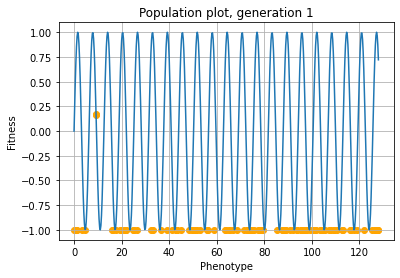

Average fitness of generation 1 is -0.9766591179464502
Population size = 100


Max age: 2 | Min age: 1


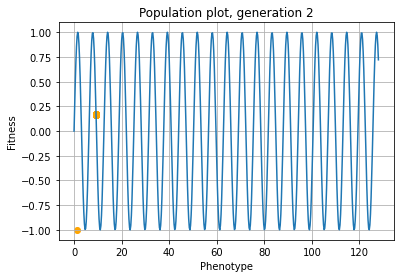

Average fitness of generation 2 is 0.1561793417156776
Population size = 100


Max age: 3 | Min age: 1


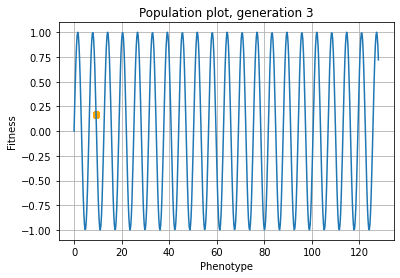

Average fitness of generation 3 is 0.16846700716505925
Population size = 100


Max age: 4 | Min age: 1


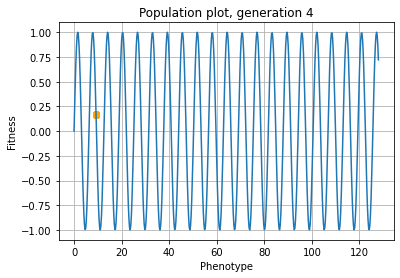

Average fitness of generation 4 is 0.16869589316893996
Population size = 100


Max age: 5 | Min age: 1


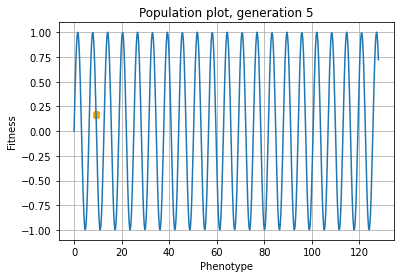

Average fitness of generation 5 is 0.16941205424120523
Population size = 100


Max age: 6 | Min age: 1


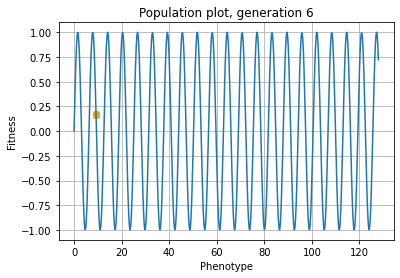

Average fitness of generation 6 is 0.16895386650221578
Population size = 100


Max age: 7 | Min age: 1


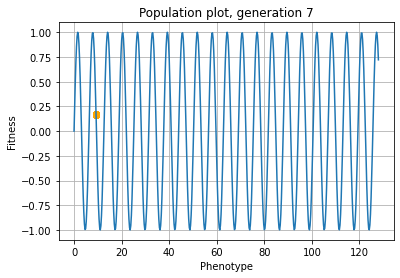

Average fitness of generation 7 is 0.16860664458207303
Population size = 100


Max age: 5 | Min age: 1


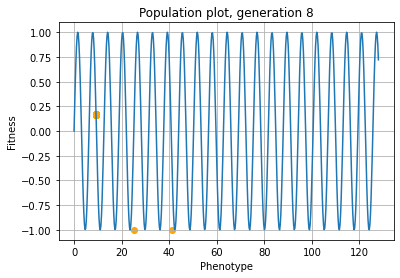

Average fitness of generation 8 is 0.145395101652555
Population size = 100


Max age: 6 | Min age: 1


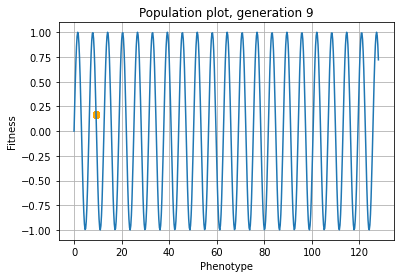

Average fitness of generation 9 is 0.16892925268808945
Population size = 100


Max age: 5 | Min age: 1


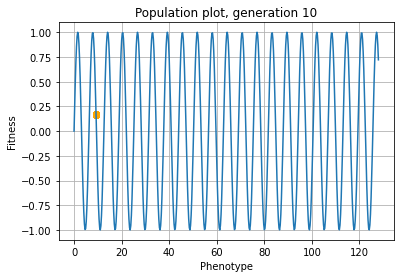

Average fitness of generation 10 is 0.16895763020348514
Population size = 100




In [13]:
enable_constraint = (True, [5, 10])

population = sga(survivor_selection = 'age', use_dataset=False)

## For the feature selection problem

*g) Run the genetic algorithm on the provided dataset. Show the results, and
compare them to the results of not using any feature selection (given by
running the linear regression with all features selected). The points given here
depend on the achieved quality of the result and team size.*

- *For a 2-person team RMSE less than 0.124.*

Updating the chromosonme_length to match the dataset. **NOTE UNSURE OF THIS**

In [34]:
chromosome_length = data.shape[1]
enable_constraint = (False, [5, 10])
g_max = 100

### Running the genetic algorithm on the provideded dataset using feature selection

In [35]:
population = sga(survivor_selection = 'age', use_dataset=True, threshold=0.124)

Max age: 1 | Min age: 1
Average fitness of generation 1 is 0.15445640767743343 
| Fitnees lower bound = 0.05472441777570715 | Fitnnes upper bound = 0.2442389633161176
Population size = 100


Max age: 2 | Min age: 1
Average fitness of generation 2 is 0.1532387888875281 
| Fitnees lower bound = 0.05472441777570715 | Fitnnes upper bound = 0.23123710890113025
Population size = 100


Max age: 3 | Min age: 1
Average fitness of generation 3 is 0.1571616016948127 
| Fitnees lower bound = 0.08035955151984461 | Fitnnes upper bound = 0.2233973225019027
Population size = 100


Max age: 4 | Min age: 1
Average fitness of generation 4 is 0.14377258368149914 
| Fitnees lower bound = 0.08046142555900872 | Fitnnes upper bound = 0.2166742211460527
Population size = 100


Max age: 5 | Min age: 1
Average fitness of generation 5 is 0.13909674801517824 
| Fitnees lower bound = 0.08071679881058076 | Fitnnes upper bound = 0.2168545124357305
Population size = 100


Max age: 6 | Min age: 1
Average fitness of gen

### Running the genetic algorithm on the provideded dataset **without** using feature selection

Not sure if i interpreted this correctly

In [25]:
regressor.get_fitness(data.values[:,:-1], data.values[:,-1])

0.1419134725520099

*h) Implement a new survivor selection function. This function should be using a
crowding technique as described in the section about crowding. Do exercise f)
and g) again with the new selection function, and compare the results to using
the simple genetic algorithm. Also show and compare how the entropies of
the different approaches (SGA and crowding) change through the generations
through a plot.*

- For a 2-person team: implement and demonstrate two crowding
approaches.

Here we have implemented two crowding methods. We have implemented deterministic and probabilistic replacement for crowding according to Mahfoud (as detailed in the lecture slides).

In [ ]:

def mahfoud_crowding(c1, c2, p1, p2, use_dataset, replacement_method):
    if hamming_distance(p1.genotype, c1.genotype) + hamming_distance(p2.genotype, c2.genotype) \
    < hamming_distance(p1.genotype, c2.genotype) + hamming_distance(p2.genotype, c1.genotype):
        
        # p1 agains  c1
        person_a = replacement_method(p1, c1, use_dataset)
        # p2 against c2
        person_b = replacement_method(p2, c2, use_dataset)

        return person_a, person_b
    else:
        # p1 against c2
        person_a = replacement_method(p1, c2, use_dataset)
        # p2 against c1
        person_b = replacement_method(p2, c1, use_dataset)

        return person_a, person_b


def deterministic_crowding(parent, child, use_dataset):
    p_fitness, c_fitness = get_fitness(parent, child, use_dataset)
    if c_fitness > p_fitness:
        return child
    elif c_fitness > p_fitness:
        return parent
    else:
        # If the their fitnesses are the same, this picks either with a 50% likelihood. 
        return random.choices([child, parent], weights=[0.5, 0.5], k=1)[0]
    return 

def probablistic_crowding(parent, child, use_dataset):
    p_fitness, c_fitness = get_fitness(parent, child, use_dataset)
    # Probability that the child replaces the parent
    p = (c_fitness) / (c_fitness + p_fitness)

    return random.choices([child, parent], weights=[p, 1 - p], k=1)[0]

def get_fitness(parent, child, use_dataset):
    if use_dataset:
        return parent.rmse_fitness, child.rmse_fitness
    else:
        return parent.sin_fitness, child.sin_fitness


def hamming_distance(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strings must be of equal length")

    return sum(c1 != c2 for c1, c2 in zip(str1, str2))


### Now doing task f) 

- The goal is to compare our crowding methods with normal SGA. We will also present a plot on the entropy.


In [ ]:
enable_constraint = (True, [5, 10])
g_max = 10

In [ ]:
population_crowding, entropy_points_crowding = sga(survivor_selection=None, use_dataset=False, 
                          crowding=(mahfoud_crowding, deterministic_crowding), enable_entropy=True)

In [ ]:
population_sga, entropy_points_sga = sga(survivor_selection='age', use_dataset=False,
                                         enable_entropy=True)

### Comparing entropies

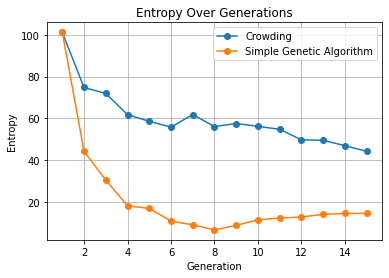

In [ ]:
generations = [point[0] for point in entropy_points_crowding]
entropies = [point[1] for point in entropy_points_crowding]
plt.plot(generations, entropies, marker='o', label='Crowding')  

generations = [point[0] for point in entropy_points_sga]
entropies = [point[1] for point in entropy_points_sga]
plt.plot(generations, entropies, marker='o', label='Simple Genetic Algorithm')  

plt.xlabel('Generation')
plt.ylabel('Entropy')
plt.title('Entropy Over Generations')
plt.grid(True) 
plt.legend()

plt.show()

### Comparing Results

Its seems that the implementation with crowding yields a higher average fitness. It also clear from the entropy plot that the crowding GA mantains diversity better than the simple SGA with increasing genenerations. This finding is consistent with the description for project 1A.

## Now doing task g)